In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

2024-03-28 22:38:20.924717: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 22:38:20.924762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 22:38:20.924791: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 22:38:20.932271: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv(r"../unsw_dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv(r"../unsw_dataset/UNSW_NB15_testing-set.csv")


In [3]:
df = pd.concat([train,test])

In [4]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [5]:
df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)  

In [7]:
print(df.duplicated().sum(), "fully duplicate rows to remove")

0 fully duplicate rows to remove


In [8]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['attack_cat'] = le.fit_transform(df['attack_cat'])

# Split your data into X and y
X = df_encoded.drop('attack_cat', axis=1)
y = df_encoded['attack_cat']

In [9]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# One-hot encode categorical features
categorical_columns = ['proto', 'service', 'state']  # Specify your categorical columns
X = pd.get_dummies(df.drop('attack_cat', axis=1), columns=categorical_columns)
y = df['attack_cat']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)


In [11]:
X_train

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
102468,102469,0.210396,10,10,1000,4664,90.305896,62,252,3.422118e+04,...,False,False,False,True,False,False,False,False,False,False
64802,64803,5.619431,138,38,162294,2612,31.141943,62,252,2.293727e+05,...,False,False,False,True,False,False,False,False,False,False
33634,33635,0.000977,2,2,132,164,3070.624396,31,29,5.404299e+05,...,False,True,False,False,False,False,False,False,False,False
27874,27875,0.037950,60,62,3614,50036,3188.405658,31,29,7.491962e+05,...,False,False,False,True,False,False,False,False,False,False
99000,99001,0.767809,22,30,1040,18514,66.422771,62,252,1.034632e+04,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37547,37548,0.031852,60,62,3598,48710,3798.819605,31,29,8.888610e+05,...,False,False,False,True,False,False,False,False,False,False
21362,21363,0.191118,22,26,2054,2582,245.921365,31,29,8.208541e+04,...,False,False,False,True,False,False,False,False,False,False
49600,49601,1.394700,12,10,2026,788,15.057001,254,252,1.065749e+04,...,False,False,False,True,False,False,False,False,False,False
64535,64536,0.754238,22,36,1040,26328,75.572961,62,252,1.053248e+04,...,False,False,False,True,False,False,False,False,False,False


In [10]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical




# Initialize the LinearSVC classifier with the best hyperparameters
classifier_SVM3 = LinearSVC(C=1, loss='squared_hinge', multi_class='ovr', max_iter=1000, class_weight='balanced')

# Cross-validation
print("Starting 3-fold cross-validation...")
start = time.time()
cv_scores = cross_val_score(classifier_SVM3, X_train_scaled, y_train_encoded, cv=3, scoring='accuracy')
end = time.time()
print(f"\n3-Fold Cross-Validation Results: Accuracy = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"\nTime taken for 3-fold cross-validation: {end - start:.2f} seconds")

print("\nTraining with best hyperparameters...")
start = time.time()
classifier_SVM3.fit(X_train_scaled, y_train_encoded)
end = time.time()
training_time = end - start

print("\nPredicting on test set...")
start = time.time()
y_predicted = classifier_SVM3.predict(X_test_scaled)
y_predicted_proba = classifier_SVM3.decision_function(X_test_scaled)
end = time.time()
predict_time = end - start

loss = log_loss(y_test_one_hot, y_predicted_proba)

print(f"\nTraining Time: {training_time:.2f} seconds")
print(f"Prediction Time: {predict_time:.2f} seconds")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_predicted))

print(f"\nLog Loss: {loss:.4f}")


Starting 3-fold cross-validation...


/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: 


3-Fold Cross-Validation Results: Accuracy = 0.7985 ± 0.0020

Time taken for 3-fold cross-validation: 100.44 seconds

Training with best hyperparameters...

Predicting on test set...

Training Time: 73.56 seconds
Prediction Time: 0.02 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.24      0.20       538
           1       0.06      0.13      0.08       471
           2       0.35      0.60      0.44      3293
           3       0.83      0.43      0.57      8853
           4       0.75      0.75      0.75      4742
           5       0.99      0.97      0.98     11849
           6       1.00      1.00      1.00     18675
           7       0.56      0.51      0.53      2770
           8       0.16      0.50      0.24       318
           9       0.02      0.73      0.04        26

    accuracy                           0.80     51535
   macro avg       0.49      0.59      0.48     51535
weighted avg       0.86      

/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2969: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


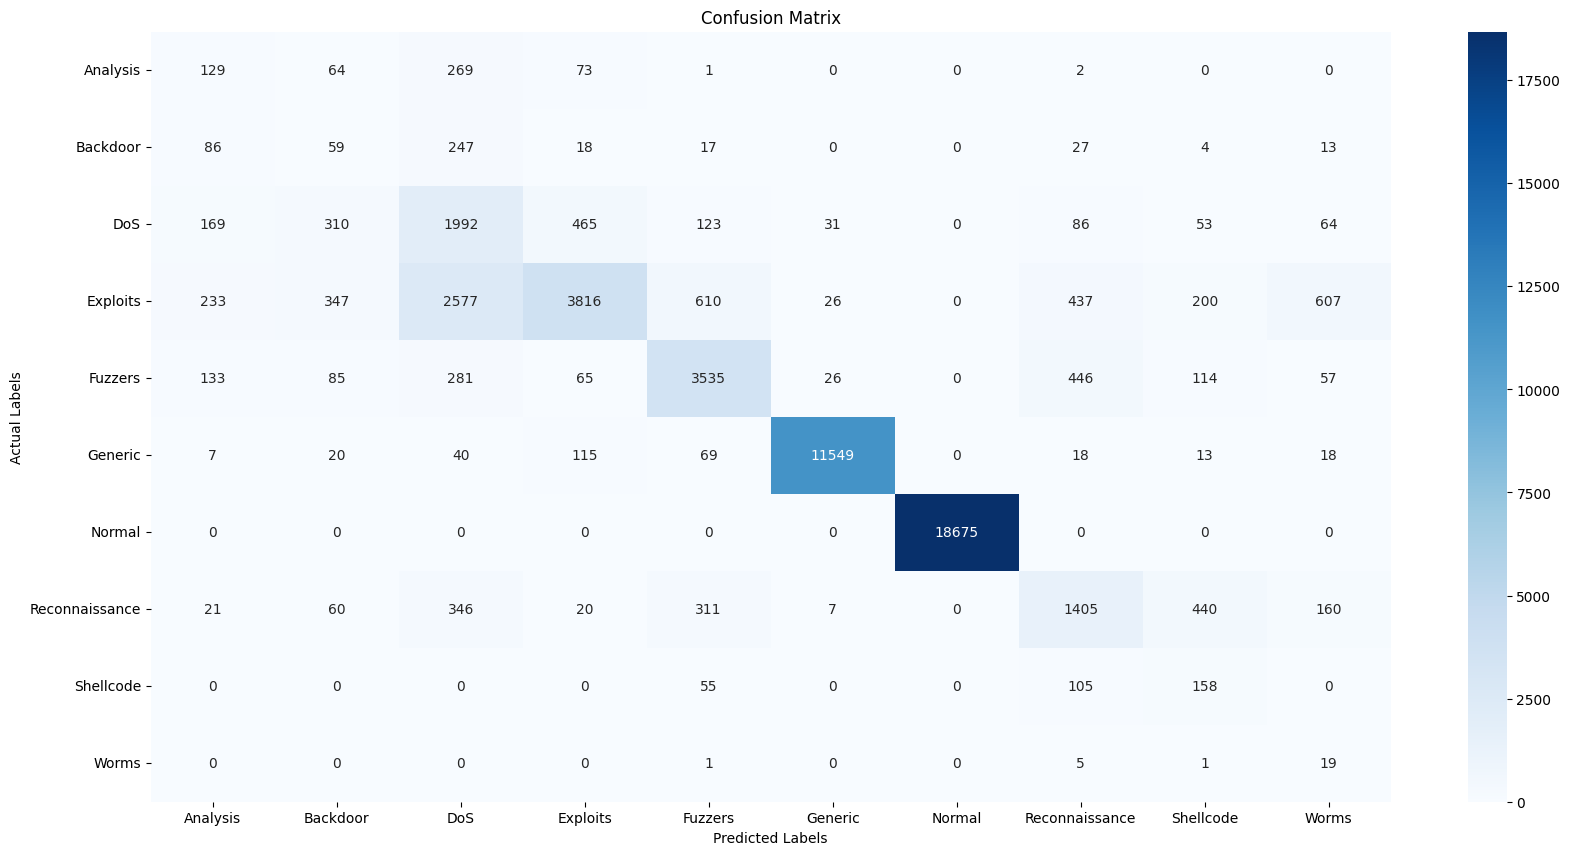

In [11]:
cm = confusion_matrix(y_test_encoded, y_predicted)

# Plot confusion matrix using seaborn
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


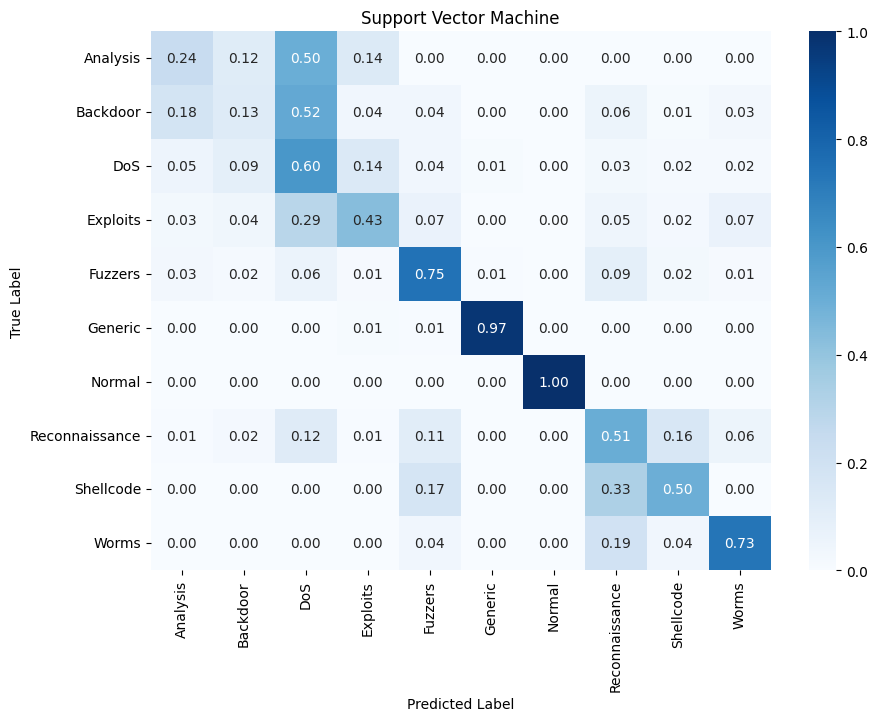

In [12]:
# Normalize the confusion matrix by rows
row_sums = cm.sum(axis=1)
conf_matrix_normalized = cm / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Support Vector Machine")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [13]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

accuracy = accuracy_score(y_test_encoded, y_predicted)



precision_weighted, recall_weighted, f1_score_weighted, _ = precision_recall_fscore_support(y_test_encoded, y_predicted, average='weighted')
print(f"Weighted Average Precision: {precision_weighted:.4f}")
print(f"Weighted Average Recall: {recall_weighted:.4f}")
print(f"Weighted Average F1-Score: {f1_score_weighted:.4f}")

precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_test_encoded, y_predicted, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")

print(f"Overall Accuracy: {accuracy:.4f}")


Weighted Average Precision: 0.8581
Weighted Average Recall: 0.8021
Weighted Average F1-Score: 0.8158
Micro Average Precision: 0.4886
Micro Average Recall: 0.5856
Micro Average F1-Score: 0.4831
Overall Accuracy: 0.8021


In [14]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization, LSTM, SpatialDropout1D,Bidirectional, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
train = pd.read_csv(r"../unsw_dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv(r"../unsw_dataset/UNSW_NB15_testing-set.csv")


In [16]:
df = pd.concat([train,test])

In [17]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [18]:
from itertools import combinations
def data_cleaning(df):
    df.columns=df.columns.str.strip()
    print("Dataset Shape: ",df.shape)
    
    num=df._get_numeric_data()
    num[num<0]=0
    
    zero_variance_cols=[]
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(columns=zero_variance_cols, axis=1, inplace=True)
    print("Zero Variance Columns: ", zero_variance_cols, "are dropped.")
    print("Shape after removing the zero varaince columns: ",df.shape)
    
    df.replace([np.inf,-np.inf],np.nan,inplace=True)
    print(df.isna().any(axis=1).sum(),"rows dropped")
    df.dropna(inplace=True)
    print("Shape after Removing NaN: ",df.shape)
    
    df.drop_duplicates(inplace=True)
    print("Shape after dropping duplicates: ",df.shape)
    
    column_pairs = [(i,j) for i,j in combinations(df,2) if df[i].equals(df[j])]
    ide_cols=[]
    for col_pair in column_pairs:
        ide_cols.append(col_pair[1])
    df.drop(columns=ide_cols,axis=1,inplace=True)
    print("Columns which have identical values: ",column_pairs," dropped!")
    print("Shape after removing identical value columns: ",df.shape)
    return df
df=data_cleaning(df)

Dataset Shape:  (257673, 45)
Zero Variance Columns:  [] are dropped.
Shape after removing the zero varaince columns:  (257673, 45)
0 rows dropped
Shape after Removing NaN:  (257673, 45)
Shape after dropping duplicates:  (257673, 45)
Columns which have identical values:  []  dropped!
Shape after removing identical value columns:  (257673, 45)


In [19]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['attack_cat'] = le.fit_transform(df['attack_cat'])

X = df_encoded.drop('attack_cat', axis=1)
y = df_encoded['attack_cat']

In [21]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

categorical_columns = ['proto', 'service', 'state']  # Specify your categorical columns
X = pd.get_dummies(df.drop('attack_cat', axis=1), columns=categorical_columns)
y = df['attack_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import pandas as pd

In [22]:
# Define the sampling strategies
sampling_strategy_over = {
    "Generic": 50000,
    "Exploits": 45000,
    "Fuzzers": 25000,
    "DoS": 15000,
    "Reconnaissance": 12000,
    "Analysis": 3000,
    "Backdoor": 2000,
    "Shellcode": 2000,
    "Worms": 500
}

sampling_strategy_under = {
    "Normal": 70000
}

# Apply SMOTE for oversampling and RandomUnderSampler for downsampling
over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)

In [23]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)

print(y_train_res.value_counts())

attack_cat
Normal            70000
Generic           50000
Exploits          45000
Fuzzers           25000
DoS               15000
Reconnaissance    12000
Analysis           3000
Backdoor           2000
Shellcode          2000
Worms               500
Name: count, dtype: int64


In [24]:


# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_res)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)


In [25]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


model = LinearSVC(C=1, loss='squared_hinge', multi_class='ovr', max_iter=1000, class_weight='balanced')

print("Starting 3-fold cross-validation...")
start = time.time()
cv_scores = cross_val_score(model, X_train_scaled, y_train_encoded, cv=3, scoring='accuracy')
end = time.time()
print(f"\n3-Fold Cross-Validation Results: Accuracy = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"\nTime taken for 3-fold cross-validation: {end - start:.2f} seconds")

print("\nTraining with best hyperparameters...")
start = time.time()
model.fit(X_train_scaled, y_train_encoded)
end = time.time()
training_time = end - start

print("\nPredicting on test set...")
start = time.time()
y_predicted = model.predict(X_test_scaled)
y_predicted_proba = model.decision_function(X_test_scaled)
end = time.time()
predict_time = end - start

loss = log_loss(y_test_one_hot, y_predicted_proba)

print(f"\nTraining Time: {training_time:.2f} seconds")
print(f"Prediction Time: {predict_time:.2f} seconds")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_predicted))

print(f"\nLog Loss: {loss:.4f}")


Starting 3-fold cross-validation...


/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: 


3-Fold Cross-Validation Results: Accuracy = 0.7684 ± 0.0019

Time taken for 3-fold cross-validation: 95.67 seconds

Training with best hyperparameters...

Predicting on test set...

Training Time: 62.65 seconds
Prediction Time: 0.02 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.23      0.22       538
           1       0.07      0.18      0.10       471
           2       0.34      0.59      0.43      3293
           3       0.84      0.43      0.57      8853
           4       0.75      0.75      0.75      4742
           5       0.99      0.97      0.98     11849
           6       1.00      1.00      1.00     18675
           7       0.60      0.37      0.46      2770
           8       0.15      0.56      0.23       318
           9       0.01      0.88      0.03        26

    accuracy                           0.79     51535
   macro avg       0.50      0.60      0.48     51535
weighted avg       0.86      0

/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2969: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [26]:
print(classification_report(y_test_encoded, y_predicted))


              precision    recall  f1-score   support

           0       0.22      0.23      0.22       538
           1       0.07      0.18      0.10       471
           2       0.34      0.59      0.43      3293
           3       0.84      0.43      0.57      8853
           4       0.75      0.75      0.75      4742
           5       0.99      0.97      0.98     11849
           6       1.00      1.00      1.00     18675
           7       0.60      0.37      0.46      2770
           8       0.15      0.56      0.23       318
           9       0.01      0.88      0.03        26

    accuracy                           0.79     51535
   macro avg       0.50      0.60      0.48     51535
weighted avg       0.86      0.79      0.81     51535



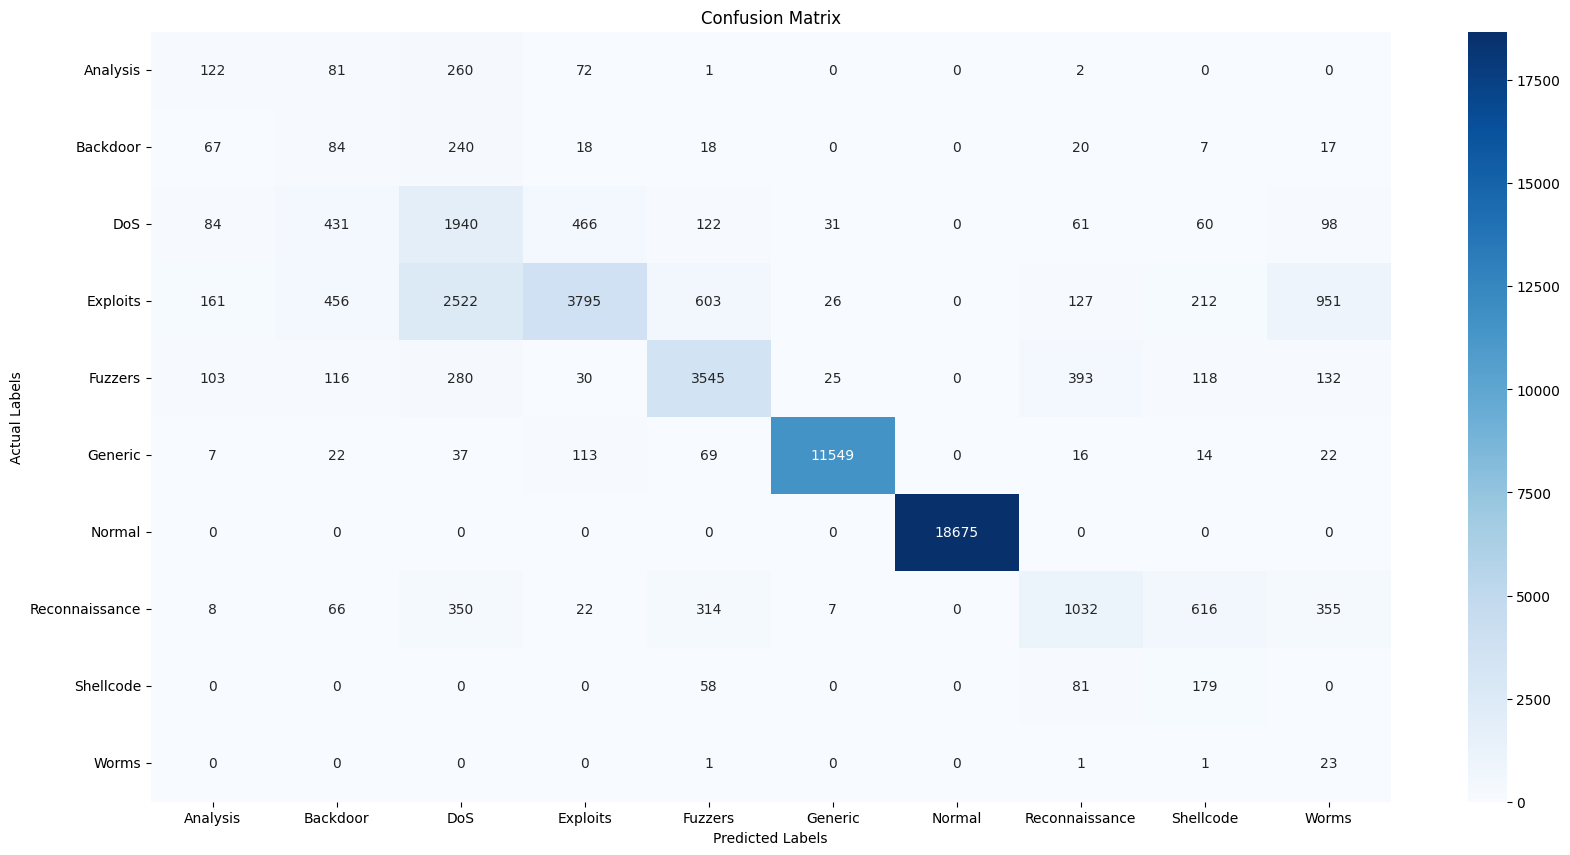

In [27]:
cm = confusion_matrix(y_test_encoded, y_predicted)

# Plot confusion matrix using seaborn
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


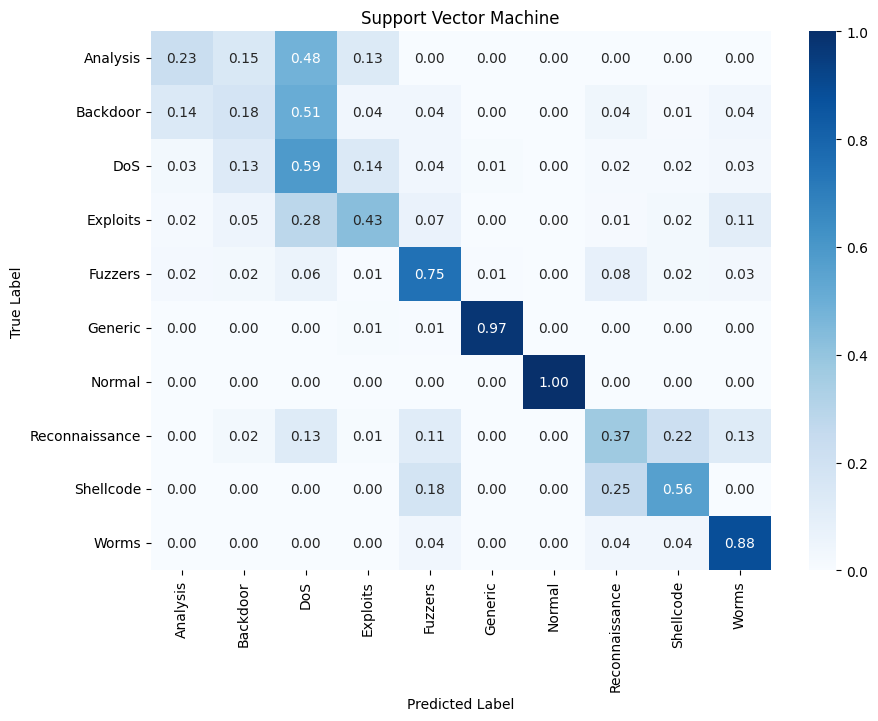

In [28]:
# Normalize the confusion matrix by rows
row_sums = cm.sum(axis=1)
conf_matrix_normalized = cm / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Support Vector Machine")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [29]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

accuracy = accuracy_score(y_test_encoded, y_predicted)



precision_weighted, recall_weighted, f1_score_weighted, _ = precision_recall_fscore_support(y_test_encoded, y_predicted, average='weighted')
print(f"Weighted Average Precision: {precision_weighted:.4f}")
print(f"Weighted Average Recall: {recall_weighted:.4f}")
print(f"Weighted Average F1-Score: {f1_score_weighted:.4f}")

precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_test_encoded, y_predicted, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")

print(f"Overall Accuracy: {accuracy:.4f}")


Weighted Average Precision: 0.8617
Weighted Average Recall: 0.7945
Weighted Average F1-Score: 0.8120
Micro Average Precision: 0.4973
Micro Average Recall: 0.5965
Micro Average F1-Score: 0.4777
Overall Accuracy: 0.7945
